# TensorFlores - Example 4

## 1. Importing libraries

In [1]:
import sys, os
path = os.getcwd().split('\\examples')[0]
sys.path.append(path)

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflores.utils.cpp_generation import CppGeneration
from tensorflores.utils.clustering import ClusteringMethods
from tensorflores.utils.json_handle import JsonHandle
from tensorflores.utils.quantization import Quantization

## 2. Load Dataset

In [3]:
df = pd.read_csv(path + '\\data\\emission_total.csv')
df.head(5)

,CO2 (g/s) [estimated maf],CO2 (g/s) [maf],estimated_maf,intake_pressure,intake_temperature,latitude,longitude,maf,rpm,speed
0,0.809921,0.639659,3.798529,26.0,54.0,-5.793477,-35.198093,3.0,1568.0,43.0
1,1.796942,2.132196,8.427658,57.0,53.0,-5.793538,-35.198116,10.0,1582.0,43.0
2,2.199995,2.132196,10.317979,69.0,53.0,-5.793600,-35.198139,10.0,1600.0,43.0
3,1.226761,0.639659,5.753511,38.0,54.0,-5.793665,-35.198170,3.0,1625.0,44.0
4,0.756202,0.426439,3.546585,24.0,54.0,-5.793739,-35.198196,2.0,1586.0,45.0


In [4]:
scaler = MinMaxScaler()
values_df = scaler.fit_transform(df[['intake_pressure', 'intake_temperature', 'speed', 'CO2 (g/s) [maf]']])

In [5]:
X = values_df[:,0:3]
y = values_df[:,3:]

## 3. Splitting the data

In [6]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

## 4. Define the model

In [8]:
model = tf.keras.Sequential()
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1))

## 5. Compile the model

In [9]:
# configure the optimizer, loss, and metrics to monitor.
opt = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        name='Adam')

# Compile the model
model.compile(optimizer=opt, loss='mse', metrics=["mse"])

## 6. Training model

In [22]:
history = model.fit(X_train, y_train,
                    batch_size=36,
                    epochs=100,
                    validation_split = 0.1,
                    verbose=1)

Epoch 1/100
205/205 [==============================] - 1s 4ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 2/100
205/205 [==============================] - 1s 4ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/100
205/205 [==============================] - 1s 4ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 4/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 5/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 6/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 7/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/100
205/205 [==============================] - 1s 3ms/step - 

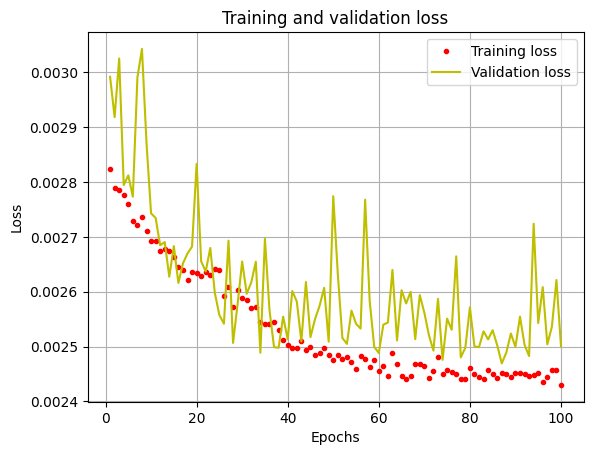

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [24]:
model.save('model.keras')

In [25]:
print('Input test: ', X_test[0])

Input test:  [0.07407407 0.07142857 0.94936709]


In [26]:
print('Predict test: ', model.predict(X_test)[0])

64/64 [==============================] - 0s 5ms/step
Predict test:  [0.08675538]


In [34]:
error = model.predict(X_test) - y_test

64/64 [==============================] - 0s 2ms/step


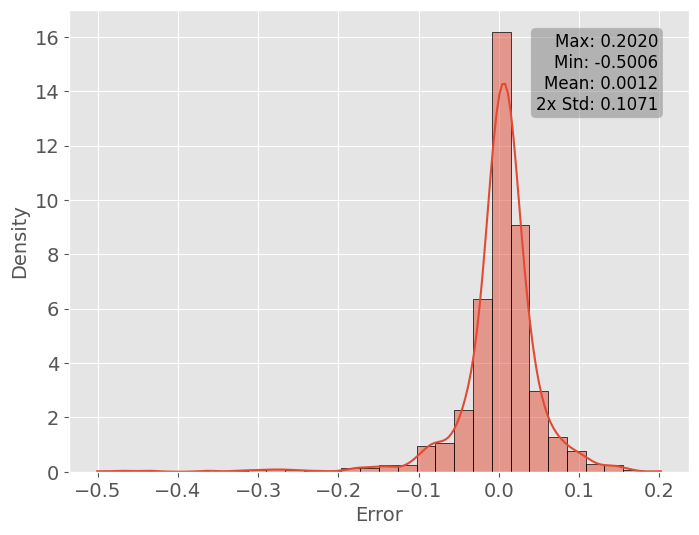

In [44]:
# Estatísticas
error_mean = np.mean(error)
error_std = np.std(error)
error_max = np.max(error)
error_min = np.min(error)

# Criando a figura e os eixos
fig, ax = plt.subplots(figsize=(8, 6))

# Estilo do gráfico
plt.style.use('ggplot')

# Plotando histograma com KDE (Densidade) sem legenda
sns.histplot(error, bins=30, color='coral', edgecolor='black', stat="density", kde=True, legend=False, ax=ax)

# Configuração dos eixos
ax.set_xlabel('Error', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
#ax.set_title('Error Distribution', fontsize=15)
ax.tick_params(labelsize=14)
ax.grid(True)

# Definindo limites do eixo X
#ax.set_xlim(error_min, error_max)

# Exibir os valores estatísticos no gráfico
textstr = '\n'.join((
    f'Max: {error_max:.4f}',
    f'Min: {error_min:.4f}',
    f'Mean: {error_mean:.4f}',
    f'2x Std: {2 * error_std:.4f}'
))
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.savefig('./figures/example_04_tensorflow.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
# Exibir gráfico
plt.show()

## 7. TensorFlores converter

### 7.2 Convert the Tensorflow model, using post quantization int8 and total (weights eand biases)

#### 7.2.1 Save as Json

In [39]:
model_as_json = JsonHandle().convert_tensorflow_model_to_json(tensorflow_model = model)
model_as_json

{'num_layers': 3,
 'model_quantized': False,
 'layers': [{'activation': 'relu',
   'weights': [[-0.055946290493011475,
     0.25544336438179016,
     -0.1677962690591812,
     -0.24042336642742157,
     -0.3851415812969208,
     0.13297191262245178,
     -0.2959812879562378,
     -0.627983570098877,
     -0.23762357234954834,
     0.14383621513843536,
     0.19565051794052124,
     0.4166729748249054,
     0.10857810080051422,
     0.0682215467095375,
     -0.12774406373500824,
     -0.18944166600704193],
    [-0.010265938937664032,
     0.02899676002562046,
     -0.05181903392076492,
     -0.027036717161536217,
     0.09078267216682434,
     0.2171010971069336,
     0.33169761300086975,
     0.2999674677848816,
     -0.28696271777153015,
     0.010510396212339401,
     0.3113749623298645,
     -0.11481685936450958,
     -0.014491205103695393,
     0.24176064133644104,
     0.009042521938681602,
     0.2737092673778534],
    [0.5430805683135986,
     -0.0355449914932251,
     0.7996528

In [41]:
cpp_model = CppGeneration().generate_cpp_from_json(json_data = model_as_json, file_name = 'tensorflow_model')

Model C++ saved!


In [29]:

Clustering_method = ClusteringMethods()

bias_clustering_method = Clustering_method.autocloud_biases(threshold_biases = 1.4148)
weight_clustering_method = Clustering_method.autocloud_weight(threshold_weights = 1.4148)
Quantization().post_training_quantization(json_data = model_as_json, quantization_type = 'evolving', distance_metric = "euclidean", 
        bias_clustering_method = bias_clustering_method,
        weight_clustering_method = weight_clustering_method)

{'num_layers': 3,
 'model_quantized': 'evolving',
 'layers': [{'activation': 'relu',
   'weights': [[6, 5, 4, 4, 1, 0, 4, 1, 4, 0, 0, 3, 0, 6, 4, 4],
    [6, 6, 6, 6, 0, 0, 5, 5, 4, 6, 5, 4, 6, 5, 6, 5],
    [2, 6, 2, 6, 1, 6, 0, 1, 6, 1, 5, 2, 1, 0, 2, 4]],
   'biases': [1, 0, 0, 2, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0]},
  {'activation': 'relu',
   'weights': [[2, 3, 5, 5, 1, 1, 4, 1],
    [2, 4, 3, 0, 5, 5, 6, 6],
    [1, 4, 1, 2, 2, 2, 6, 6],
    [1, 1, 1, 0, 4, 3, 4, 6],
    [4, 1, 4, 0, 1, 4, 6, 3],
    [0, 0, 1, 0, 4, 4, 5, 5],
    [4, 3, 1, 0, 5, 3, 6, 5],
    [0, 4, 1, 0, 5, 5, 5, 3],
    [1, 6, 1, 5, 4, 5, 5, 6],
    [6, 1, 6, 2, 0, 2, 5, 4],
    [6, 4, 1, 1, 4, 1, 6, 0],
    [5, 3, 4, 1, 1, 1, 0, 6],
    [0, 4, 5, 1, 4, 0, 3, 5],
    [0, 2, 6, 4, 0, 4, 1, 5],
    [5, 0, 0, 6, 3, 6, 4, 5],
    [4, 0, 5, 4, 3, 6, 5, 4]],
   'biases': [2, 2, 1, 2, 0, 1, 1, 1]},
  {'activation': 'linear',
   'weights': [[3], [0], [3], [1], [1], [2], [1], [6]],
   'biases': [2]}],
 'centers_bias': 

In [42]:
cpp_model = CppGeneration().generate_cpp_from_json(json_data = model_as_json, file_name = 'tensorflow_evolving')

Model C++ saved!


In [31]:
model_as_json_int8 = Quantization().post_training_quantization(json_data = model_as_json,
                                        quantization_type = 'int8')

In [32]:
model_as_json_int8

{'num_layers': 3,
 'model_quantized': 'int8',
 'layers': [{'activation': 'relu',
   'weights': [[145,
     183,
     132,
     123,
     105,
     168,
     116,
     76,
     123,
     170,
     176,
     203,
     165,
     161,
     137,
     129],
    [151,
     156,
     146,
     149,
     163,
     179,
     193,
     189,
     117,
     154,
     190,
     138,
     151,
     182,
     153,
     186],
    [218,
     148,
     249,
     144,
     99,
     153,
     173,
     86,
     158,
     13,
     194,
     228,
     101,
     163,
     221,
     118]],
   'biases': [113,
    156,
    146,
    185,
    151,
    144,
    174,
    164,
    148,
    163,
    135,
    135,
    143,
    162,
    151,
    154]},
  {'activation': 'relu',
   'weights': [[255, 207, 187, 196, 14, 93, 115, 0],
    [236, 133, 201, 170, 191, 183, 146, 143],
    [65, 136, 106, 212, 224, 222, 148, 158],
    [66, 81, 96, 163, 132, 203, 124, 156],
    [130, 99, 117, 177, 92, 137, 147, 207],
    [177, 175, 9

In [43]:
cpp_model_int8 = CppGeneration().generate_cpp_from_json(json_data = model_as_json_int8, file_name = 'tensorflow_int8')

Model C++ saved!
